In [ ]:
import torch
import triton
import triton.language as tl
from transformers.models.llama.modeling_llama import LlamaRMSNorm

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- RMSNorm的实现，写了详细的求导过程，帮助理解
- 对比torch内置和hf-llama的

# core

### 1 RMSNorm前向传播
#### x是一个N维向量，“*” 是element-wise的乘法
$$y=RMSNorm(x) = \frac{x}{\sqrt{\sum_{i=1}^N x_i^2 + eps}} * weight$$
### 2 反向传播推导
#### $\frac{\partial L}{\partial y}$是Loss对y的导数
#### $\frac{\partial L}{\partial x}$是Loss对x的导数
#### $\frac{\partial L}{\partial w}$是L对w的导数
#### $\hat{x} = \frac{x}{\sqrt{\sum_{i=1}^N x_i^2 + eps}}$
#### $std = \sqrt{\sum_{i=1}^N x_i^2 + eps}$
### 2.1 求dw
$$
\begin{aligned}
\frac{\partial L}{\partial w_i} &= \sum_{j=1}^N \frac{\partial y_j}{\partial w_i} \frac{\partial L}{\partial y_j}\\
&= \frac{\partial y_i}{\partial w_i} \frac{\partial L}{\partial y_i}\\
&= \hat{x_{i}} \frac{\partial L}{\partial y_i}
\end{aligned}$$
#### 推广到向量表示
$$\frac{\partial L}{\partial w} = \hat{x} * \frac{\partial L}{\partial y}$$
### 2.2 求dx
$$\frac{\partial L}{\partial x_i} = \sum_{j=1}^N \frac{\partial y_j}{\partial x_i} \frac{\partial L}{\partial y_j}$$
#### 先求$\frac{\partial y_j}{\partial x_i}$, 下面根据乘法求导法则和链式法则, $I(i==j)$是示性函数,i=j为1否则为0
$$\begin{aligned}
\frac{\partial y_j}{\partial x_i} &= \frac{I(i==j)}{std}*w_j + x_j * (-\frac{1}{2})*\frac{1}{std^3}*\frac{1}{N}*2x_i *w_j\\
&= (I(i==j)*w_j -\frac{1}{N}*\hat{x_i}*\hat{x_j}*w_j)/std\\
\end{aligned}$$
### 带进去,第2行括号里改成内积形式
$$
\begin{aligned}
\frac{\partial L}{\partial x_i} &= \sum_{j=1}^N \frac{\partial y_j}{\partial x_i} \frac{\partial L}{\partial y_j}\\
&= (w_j * \frac{\partial L}{\partial y_i} -\frac{\hat{x_i}}{N}* (\sum_{j=1}^N \hat{x_j}*w_j*\frac{\partial L}{\partial y_j}))/std\\
&= (w_j * \frac{\partial L}{\partial y_i} -\frac{\hat{x_i}}{N}* (\hat{x^T}(w * \frac{\partial L}{\partial y})))/std
\end{aligned}$$
#### 推广到向量表示
$$\frac{\partial L}{\partial x} = (w * \frac{\partial L}{\partial y} -\frac{\hat{x}}{N}* (\hat{x^T}(w * \frac{\partial L}{\partial y})))/std$$

In [2]:
@triton.jit
def _rmsnorm_fwd(X, Y, W, RMS_STD, eps,
                 stride_n, stride_d,
                 BLOCK_N:tl.constexpr,
                 N: tl.constexpr):
    start_n = tl.program_id(0)
    offset = start_n * stride_n
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N
    x_ptrs = X + offset + cols
    y_ptrs = Y + offset + cols
    w_ptrs = W + cols

    x = tl.load(x_ptrs, mask=mask, other=0.).to(tl.float32)
    w = tl.load(w_ptrs, mask=mask, other=0.)

    rms_std = tl.sqrt(tl.sum(x * x) / N + eps)
    x_hat = x / rms_std
    y = x_hat.to(w.dtype) * w

    tl.store(y_ptrs, y, mask=mask)
    tl.store(RMS_STD+start_n, rms_std)

@triton.jit
def _rmsnorm_bwd_dx_fused(DX, DY, DW, X, W, RMS_STD, Lock,
                 stride_n, stride_d,
                 BLOCK_N:tl.constexpr, GROUP_SIZE: tl.constexpr, 
                 N: tl.constexpr):
    start_n = tl.program_id(0)
    lock_id = start_n % GROUP_SIZE
    Lock += lock_id
    Count = Lock + GROUP_SIZE
    offset = start_n * stride_n
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N
    x_ptrs = X + offset + cols
    w_ptrs = W + cols
    dx_ptrs = DX + offset + cols
    dy_ptrs = DY + offset + cols
    dw_ptrs = DW + lock_id * N + cols
    
    x = tl.load(x_ptrs, mask=mask, other=0.).to(tl.float32)
    w = tl.load(w_ptrs, mask=mask, other=0.)
    dy = tl.load(dy_ptrs, mask=mask, other=0.).to(tl.float32)
    rms_std = tl.load(RMS_STD+start_n)

    x_hat = x / rms_std
    wdy = w * dy
    dx = (wdy - (x_hat / N) * tl.sum(x_hat * wdy)) / rms_std
    tl.store(dx_ptrs, dx, mask=mask)

    partial_dw = x_hat * dy
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    # First store doesn't accumulate
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(dw_ptrs, mask=mask, other=0.)
    tl.store(dw_ptrs, partial_dw, mask=mask)
    tl.atomic_xchg(Lock, 0)

@triton.jit
def _rmsnorm_bwd_dw(PART_DW, DW,
                 stride_m, stride_d,
                 BLOCK_NN:tl.constexpr, GROUP_SIZE: tl.constexpr, 
                 N: tl.constexpr):
    group_id = tl.program_id(0)
    offset_nn = group_id*BLOCK_NN

    partial_dw_ptrs = tl.make_block_ptr(
        base=PART_DW,
        shape=(GROUP_SIZE, N),
        strides=(stride_m, stride_d),
        offsets=(0, offset_nn),
        block_shape=(GROUP_SIZE, BLOCK_NN),
        order=(1,0),
    )
    
    partial_dw = tl.load(partial_dw_ptrs, boundary_check=(1,), padding_option='zero').to(tl.float32)
    dw = tl.sum(partial_dw, 0)
    tl.store(DW + offset_nn + tl.arange(0, BLOCK_NN), dw, mask=(offset_nn+tl.arange(0, BLOCK_NN)) < N)

class _TritronRMSNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, hidden_state, weight, eps):
        input_shape = hidden_state.shape
        output = torch.empty_like(hidden_state)
        hidden_state = hidden_state.reshape(-1, input_shape[-1])
        M,N = hidden_state.shape
        BLOCK_N = triton.next_power_of_2(N)
        rms_std = torch.empty(M, dtype=torch.float32, device=hidden_state.device)
        
        num_warps=8
        num_stages=1
        _rmsnorm_fwd[(M, )](hidden_state, output, weight, rms_std, eps,
                            *hidden_state.stride(),
                            BLOCK_N,
                            N,
                            num_warps=num_warps, num_stages=num_stages)
        ctx.save_for_backward(hidden_state, weight, rms_std)
        ctx.input_shape = input_shape
        ctx.BLOCK_N = BLOCK_N
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return output
    
    @staticmethod
    def backward(ctx, dy):
        # dy = dy.contiguous()
        hidden_state, weight, rms_std = ctx.saved_tensors
        hidden_state = hidden_state.reshape(-1, hidden_state.shape[-1])
        M,N = hidden_state.shape
        input_shape = ctx.input_shape
        N = input_shape[-1]
        GROUP_SIZE = 64
        if N <= 8192: GROUP_SIZE = 64
        if N <= 4096: GROUP_SIZE = 128
        if N <= 1024: GROUP_SIZE = 256
        # GROUP_SIZE = min(1024, triton.next_power_of_2(M))
        BLOCK_NN = min(128, triton.next_power_of_2(N))

        dw = torch.empty_like(weight)
        dx = torch.empty_like(dy)
        partial_dw = torch.zeros((GROUP_SIZE, input_shape[-1]), device=weight.device, dtype=weight.dtype)
        lock = torch.zeros(GROUP_SIZE*2, device=weight.device, dtype=torch.int32)
        
        _rmsnorm_bwd_dx_fused[(M,)](dx, dy, partial_dw, hidden_state, weight, rms_std, lock,
                 *hidden_state.stride(),
                 ctx.BLOCK_N, GROUP_SIZE, 
                 N,
                 num_warps=ctx.num_warps, num_stages=ctx.num_stages)
        # print(dy[0][0][:8])
        grid = lambda meta: (triton.cdiv(N, BLOCK_NN), )
        _rmsnorm_bwd_dw[grid](partial_dw, dw,
                 *partial_dw.stride(),
                 BLOCK_NN, GROUP_SIZE, 
                 N,
                 num_warps=ctx.num_warps, num_stages=ctx.num_stages)
        return dx, dw, None

triton_rmsnorm = _TritronRMSNorm.apply
class TritonRMSNorm(torch.nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.ones(hidden_size))
        self.eps = eps
    
    def forward(self, hidden_state):
        return triton_rmsnorm(hidden_state, self.weight, self.eps)

# 精度测试

In [18]:
dim = 1024
dtype = torch.bfloat16
rmsnorm_triton = TritonRMSNorm(dim, eps=1e-6).cuda().to(dtype)
rmsnorm_llama = LlamaRMSNorm(dim, eps=1e-6).cuda().to(dtype)
rmsnorm_llama.weight.data = torch.randn(dim).cuda().to(dtype)
rmsnorm_triton.weight.data.copy_(rmsnorm_llama.weight.data)
x1 = torch.randn(128, dim).cuda().to(dtype)
x2 = torch.randn(128, dim).cuda().to(dtype)
x2.data.copy_(x1)
x1.requires_grad = True
x2.requires_grad = True
dy = torch.ones_like(x1)


In [19]:
if x1.grad is not None:
    x1.grad.zero_()
    rmsnorm_llama.weight.grad.zero_()
y1 = rmsnorm_llama(x1)
y1.backward(dy)

if x2.grad is not None:
    x2.grad.zero_()
    rmsnorm_triton.weight.grad.zero_()
y2 = rmsnorm_triton(x2)
y2.backward(dy)


print('triton vs hf-llama')
print(torch.allclose(y1, y2, 0.0001, 0.0001), (y1 - y2).abs().max().item())
print(torch.allclose(x1.grad, x2.grad, 0.0001, 0.0001), (x1.grad - x2.grad).abs().max().item())
print(torch.allclose(rmsnorm_llama.weight.grad, rmsnorm_triton.weight.grad, 0.0001, 0.0001),
      (rmsnorm_llama.weight.grad - rmsnorm_triton.weight.grad).abs().max().item())


triton vs hf-llama
True 0.0
True 0.0
True 0.0


# Forward benchmark

bs: 8, seq_len: 1024


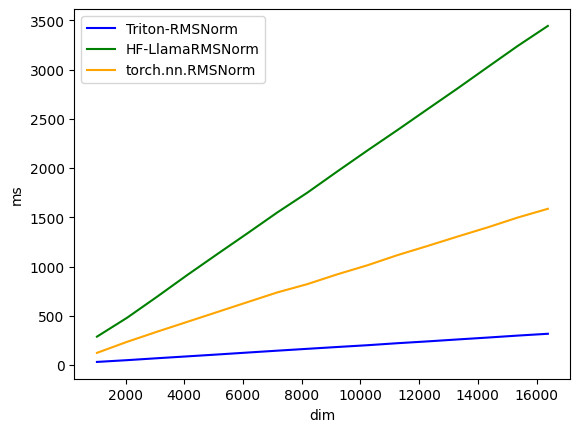

RMSNorm:
        dim  Triton-RMSNorm  HF-LlamaRMSNorm  torch.nn.RMSNorm
0    1024.0       32.070749       288.566083        123.970412
1    2048.0       49.915798       480.110556        235.781878
2    3072.0       69.519535       693.839073        338.701397
3    4096.0       88.362336       913.312972        438.422769
4    5120.0      107.340932      1125.960946        538.235307
5    6144.0      126.988173      1336.354375        638.384461
6    7168.0      146.321505      1549.585342        737.756670
7    8192.0      165.123314      1750.686765        821.991920
8    9216.0      183.721647      1966.820121        921.714246
9   10240.0      201.703176      2179.089308       1013.481259
10  11264.0      222.203583      2386.646986       1116.477847
11  12288.0      240.544379      2598.661661       1209.532857
12  13312.0      260.307759      2809.432268       1305.141449
13  14336.0      279.404908      3025.696754       1398.374438
14  15360.0      299.479455      3240.563869  

In [11]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-RMSNorm', 'HF-LlamaRMSNorm', 'torch.nn.RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-RMSNorm",
            "HF-LlamaRMSNorm",
            "torch.nn.RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'HF-LlamaRMSNorm':
        rmsnorm_llama = LlamaRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_llama(tensor))
    if provider == 'Triton-RMSNorm':
        rmsnorm_triton = TritonRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_triton(tensor))
    if provider == 'torch.nn.RMSNorm':
        rmsnorm_triton = torch.nn.RMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: rmsnorm_triton(tensor))

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# Backward benchmark

bs: 8, seq_len: 1024


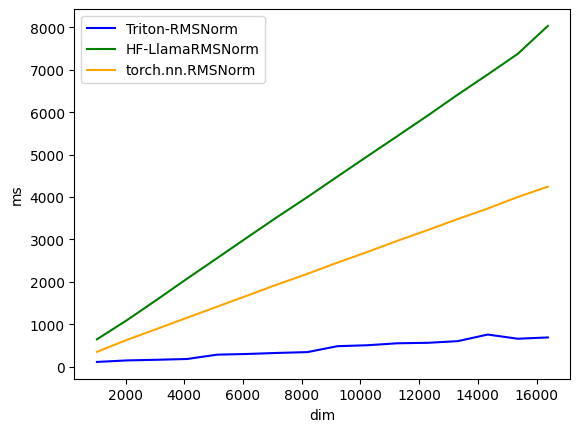

RMSNorm:
        dim  Triton-RMSNorm  HF-LlamaRMSNorm  torch.nn.RMSNorm
0    1024.0      108.952768       642.528832        346.941233
1    2048.0      144.428551      1094.965696        629.947960
2    3072.0      159.851745      1579.744101        889.861465
3    4096.0      178.226635      2074.327946       1152.318716
4    5120.0      280.705988      2558.772087       1413.405895
5    6144.0      296.814263      3046.534538       1673.278093
6    7168.0      321.035713      3529.784441       1936.617613
7    8192.0      340.530306      3997.553825       2187.480927
8    9216.0      480.045110      4482.635498       2451.771259
9   10240.0      502.629399      4963.132858       2704.412937
10  11264.0      548.975527      5439.861298       2968.029976
11  12288.0      559.680402      5920.111179       3218.852758
12  13312.0      599.050105      6414.409161       3479.526281
13  14336.0      754.658222      6891.234875       3728.314161
14  15360.0      655.978620      7378.332615  

In [9]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-RMSNorm', 'HF-LlamaRMSNorm', 'torch.nn.RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-RMSNorm",
            "HF-LlamaRMSNorm",
            "torch.nn.RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    dy = torch.ones_like(tensor)
    if provider == 'HF-LlamaRMSNorm':
        rmsnorm_llama = LlamaRMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_llama(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])

    if provider == 'Triton-RMSNorm':
        rmsnorm_triton = TritonRMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_triton(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])
    
    if provider == 'torch.nn.RMSNorm':
        rmsnorm_triton = torch.nn.RMSNorm(dim, eps=1e-6).cuda().to(dtype)
        y = rmsnorm_triton(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[tensor])
    

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


In [14]:
torch.nn.RMSNorm(5)

RMSNorm((5,), eps=None, elementwise_affine=True)